This notebook will walk you through loading the STEM image benchmark dataset
from Foundry and running atom-position finding models. An example of calculating the evaluation metrics as mentioned in the paper is also included. You can review what those metrics means in the project introduction [video](https://drive.google.com/file/d/14P_JBPdH-srDM2i8eE_EJTYfM3jP2keW/view?usp=sharing) 

## Install Foundry and import related libraries. 

In [ ]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [ ]:
!pip install foundry_ml 
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cryptography==36.0.2
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill

# Fetch benchmark dataset from Foundry


The code in the next cell will detect your environment to make sure that only cells that match your environment will run. Running in Google Colab requires a few changes compared to running locally.

In [ ]:
try:
  import google.colab
  no_local_server=True
  no_browser=True
  globus=False

  from google.colab import data_table
  data_table.enable_dataframe_formatter()

except: # when not in google colab
  no_local_server=False
  no_browser=False
  globus=True

Datasets in Foundry can be accessed by their permanent digital object identifiers (DOIs). The cell below will load the STEM benchmark dataset from Foundry using its DOI. If you have not authenicated to Globus, which provides authentication and file transfer infrastructure for Foundry, you will prompted to do so. This use of Globus is free and supports institutional user credentials for many labs and universities around the world. See <b>https://www.globus.org/</b> for more information about the Globus service and obtaining access.

Once the data loads, you should see some summary metadata about the dataset.

In [ ]:
from foundry import Foundry
f = Foundry(index="mdf", no_local_server=no_local_server, no_browser=no_browser)

doi = '10.18126/e73h-3w6n'
f = f.load(doi,download=True, globus=globus)
f

Foundry(dc={'creators': [{'affiliations': ['University of Wisconsin - Madison'], 'creatorName': 'Wei, Jingrui', 'familyName': 'Wei', 'givenName': 'Jingrui'}, {'affiliations': ['University of Chicago', 'Argonne National Laboratory'], 'creatorName': 'Blaiszik, Ben', 'familyName': 'Blaiszik', 'givenName': 'Ben'}, {'affiliations': ['University of Wisconsin - Madison'], 'creatorName': 'Morgan, Dane', 'familyName': 'Morgan', 'givenName': 'Dane'}, {'affiliations': ['University of Wisconsin - Madison'], 'creatorName': 'Voyles, Paul', 'familyName': 'Voyles', 'givenName': 'Paul'}], 'dates': [{'date': '2021-07-15', 'dateType': 'Accepted'}], 'identifier': {'identifier': '10.18126/e73h-3w6n', 'identifierType': 'DOI'}, 'publicationYear': 2021, 'publisher': 'Materials Data Facility', 'resourceType': {'resourceType': 'Dataset', 'resourceTypeGeneral': 'Dataset'}, 'subjects': [{'subject': 'machine learning'}, {'subject': 'foundry'}, {'subject': 'atom finding'}, {'subject': 'materials'}, {'subject': 'STEM'}], 'titles': [{'title': 'Benchmark Dataset for Locating Atoms in STEM images'}]}, mdf={'ingest_date': '2021-07-15T14:24:40.739344Z', 'organizations': ['Foundry'], 'resource_type': 'dataset', 'scroll_id': 0, 'source_id': 'foundry_wei_atom_locating_benchmark_v1.1', 'source_name': 'foundry_wei_atom_locating_benchmark', 'version': 1}, dataset=FoundryDataset(keys=[FoundryKey(key=['imgs'], type='input', filter='', units='', description='input, unlabeled images', classes=None), FoundryKey(key=['raw'], type='input', filter='', units='', description='raw, unlabeled images', classes=None), FoundryKey(key=['metadata'], type='input', filter='', units='', description='tabular information describing the experimental conditions and materials for each image', classes=None), FoundryKey(key=['coords'], type='target', filter='', units='', description='(x,y) coordinates for labeled atoms for each image', classes=None)], splits=[FoundrySplit(type='train', path='wei_atom.h5', label='train')], data_type=<FoundryDatasetType.hdf5: 'hdf5'>, short_name='wei_atom_locating', dataframe=None, task_type=['supervised'], domain=['materials science'], n_items=299), config=FoundryConfig(dataframe_file='foundry_dataframe.json', data_file='foundry.hdf5', metadata_file='foundry_metadata.json', destination_endpoint=None, local=False, metadata_key='foundry', organization='foundry', local_cache_dir='./data'), forge_client=<mdf_forge.forge.Forge object at 0x7f4d2d537c90>, connect_client=<mdf_connect_client.mdfcc.MDFConnectClient object at 0x7f4d2d537e10>, xtract_tokens={'auth_token': 'Ag0dNdEmJ7yPNjaQy1Xr9nqy9d9Kko0O7orlvn0j93GVgE4arwf7C3DpvvJxO0Xy2V7jN21gwKDG8eSwQNYrOCq5y7', 'transfer_token': 'AgW8Bneb067kyGV4pjjN7jxy0Mxd38rGl0zYjDw2xDvpJyw5x2tgCnpv4Nm86dbYdkKKYbkn1qbjYmH4KJmdqh5mKO', 'funcx_token': 'AgD1rBGkOnVD4r0qNkJW9nJPVQG5lmGv7oq6q1nnkOqKooG6xEUaCWjNjByVVloj5V7rNbvd8amYmXUw3gr2lCX6WX'}, index='mdf')

In [ ]:
# load the HDF5 image data into a local object
res = f.load_data()

# using the 'train' split, 'input' or 'target' type, and Foundry Keys specified by the dataset publisher
# Grab the atom images, metadata, and ground truth coorinates
imgs = res['train']['input']['imgs']
desc = res['train']['input']['metadata']
coords = res['train']['target']['coords']

A few rows of table view of the metadata will be good to clearly exibit the dataset to users. But this function is not working well now and Ben should be trying to debuging it. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Apply the model to an image to find atomic column positions

Make sure your pytorch version is the same as the one you used for model training

In [ ]:
index = 255 # the index number of the image you want to load from the whole dataset (0-298)
key = list(imgs.keys())[index]
im = np.asarray(imgs[key])

In [ ]:
# load the model you want to use and run
!pip install atomai
import atomai
import torch

In [ ]:
w = torch.load('/content/drive/MyDrive/AtomfinderProject/AtomFinder_Skunkworks/Jingrui Wei/model_0428_2336_metadict_final.tar',map_location=torch.device('cpu'))
ww = list(w.items())[8][1]
model = atomai.nets.SegResNet(nb_classes=1) # consistent with the model you are loading 
model.load_state_dict(ww) 

pseg = atomai.predictors.SegPredictor(model)
nn_output, coords = pseg.run(im)
predictpos_y, predictpos_x, _ = coords[0].T

Batch 1/1
1 image was decoded in approximately 1.9534 seconds


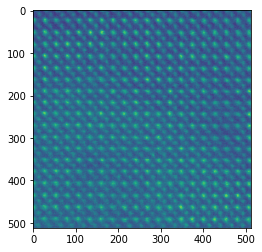

In [ ]:
# Take a quick look at the model outputs
import matplotlib.pyplot as plt
#plt.imshow(im)
plt.imshow(nn_output)
plt.scatter(predictpos_y, predictpos_x)

Next we visulize the results. Blue circles indicate ground truth positions, red dots represent the model predictions. The ground truth positions are part of the Foundry data set.

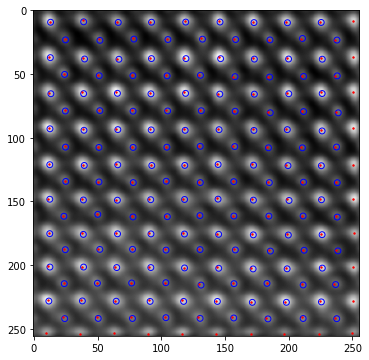

In [ ]:
#extract the ground truth positions for the same image from the Foundry dataset
truthpos_x,truthpos_y = np.transpose(coords[key])
truthnum = truthpos_y.shape[0]

#display the image with the ground truth positions and the model determined positions as overlays
fig = plt.figure(figsize=(6,6))
plt.imshow(im, cmap = 'gray')
plt.scatter(truthpos_x,truthpos_y,s = 35, facecolors='none', edgecolors = 'b')
plt.scatter(predictpos_x,predictpos_y,s = 2, c = 'red')

plt.show()

Next we will calculate the quality metrics **recall**, **precision**, and **mean position deviation** from the paper for the model identifed positions in this image.

Sometimes atomic columns at the very edges of the input image are not included in the ground truth. To keep this limitation from from disturbing the evaluation scores, we use the functions below to remove predicted atomic column positions that are too close to the edges of the image. Adjusting the edge limit parameter, set here to 0.02, will remove more or fewer columns.

In [ ]:
# define function to delete predicted atomic column positions near the edges of the image
def delete_edge_predictions(edges, shape, predictpos_x, predictpos_y):
  '''
  edges:[left, right, top, bottom] as percentage of the whole image size
  '''
  dellistx = []
  for i, coordx in enumerate (predictpos_x):
    dis = abs(coordx-shape[1])/shape[1]
    if dis> (1-edges[0]) or dis < edges[1]: 
      dellistx.append(i)
  dellisty = []
  for i, coordy in enumerate (predictpos_y):
    dis = abs(coordy-shape[0])/shape[0]
    if dis>(1-edges[2])or dis<edges[3]:
      dellisty.append(i)

  dellist = dellistx + dellisty
  dellist = np.unique(np.asarray(dellist))
  try:
    predictpos_x = np.delete(predictpos_x,dellist)
    predictpos_y = np.delete(predictpos_y,dellist)
  except:
    print('You need to re-adjust your edge values for the most accurate measurement\n')
  
  return(predictpos_x, predictpos_y)


# delete predicted atomic column positions near the edges of the image
predictpos_x_refined, predictpos_y_refined = delete_edge_predictions([0.02, 0.03, 0.02, 0.02], im.shape, predictpos_x, predictpos_y)



It's helpful to visualize the results again to check if the edge removal is appropriate.

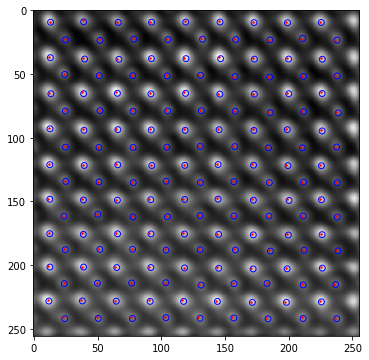

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.imshow(img, cmap = 'gray')
plt.scatter(truthpos_x,truthpos_y,s = 35, facecolors='none', edgecolors = 'b')
plt.scatter(predictpos_x_refined,predictpos_y_refined,s = 2, c = 'red')

plt.show()

In [ ]:
# define functions to calculate recall, precision, and mean position deviation by comparing model predicted positions to ground truth positions.
def getScores(predictpos_x, predictpos_y, truthpos_x, truthpos_y, truthnum, tolerance):
  truepoints = []
  pos_se = 0
  tp = 0

  for i in range(predictpos_x.size):
    for j in range(truthpos_x.size):
      square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
      if square_error < tolerance:
        truepoints.append((predictpos_y[i],predictpos_x[i]))
        pos_se = pos_se + square_error
        tp = tp + 1

  rmse = math.sqrt(pos_se / tp)
  recall = tp / truthnum
  precision = tp / predictpos_x.size
  print('position deviation = ', rmse, 'px, recall = ', tp, '/', truthnum, ' = ', recall, ', precision = ', tp, '/', predictpos_x.size, ' = ', precision)
  scores = (rmse, recall, precision)
  return scores

In [ ]:
# set the max deviation as 0.5 angstrom by recalling the pixel size of the image saved in the Foundry dataset
# You can also just set the tolerance as 5 px2, or as much as you want

tolerance = np.round((0.5/desc['table'][int(key)][1][4]*100)**2, 1) # the final unit is pixel^2
 
rmse, r, p = getScores(predictpos_x_refined, predictpos_y_refined, truthpos_x, truthpos_y, truthnum, tolerance)

position deviation =  1.2107891333262224 px, recall =  162 / 162  =  1.0 , precision =  162 / 162  =  1.0


##The last 45 images within the benchmark dataset are experimental images of various crystal lattices. You can run the model through them all and see if the three evaluation scores remain at a relatively high level.  The following plot is the comparison result of some existing models evaluated on those 45 images.
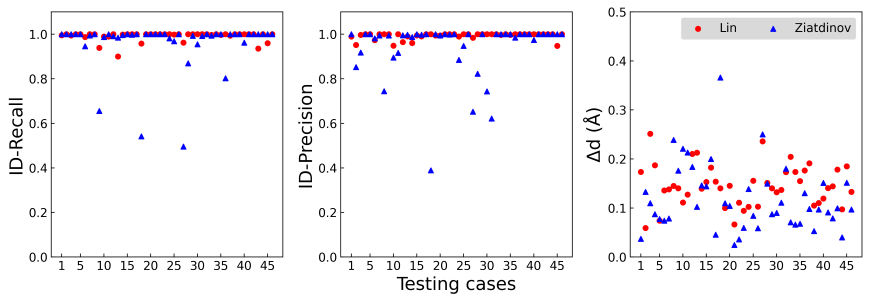
